In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision.models as models
import torch.cuda.amp as amp
import os
import shutil
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import numpy as np
import gc
import IPython
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

checkpoint_dir = "model_checkpoints"
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir, exist_ok=True)
torch.cuda.empty_cache()

In [2]:
def check_and_clear_cuda_memory():
    free_mem, total_mem = torch.cuda.mem_get_info()
    print(f"Before Clearing - Free memory: {free_mem / 1024**2:.2f} MB / {total_mem / 1024**2:.2f} MB")

    gc.collect()
    torch.cuda.empty_cache()
    IPython.display.clear_output(wait=True)  # Clear Jupyter output

    free_mem, total_mem = torch.cuda.mem_get_info()
    print(f"After Clearing - Free memory: {free_mem / 1024**2:.2f} MB / {total_mem / 1024**2:.2f} MB")

check_and_clear_cuda_memory()

After Clearing - Free memory: 11034.06 MB / 11172.19 MB


In [3]:
#seed = 42
#torch.manual_seed(seed)
#np.random.seed(seed)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
data_dir = "tiny-imagenet-200"

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
from PIL import Image
img_path = "tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG"
img = Image.open(img_path)
print(type(img))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [8]:
#subset_size = 10000  # Adjust size , max is 100000
#train_dataset_full = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
#indices = np.random.choice(len(train_dataset_full), subset_size, replace=False)  # Fixed subset indices
#train_dataset = torch.utils.data.Subset(train_dataset_full, indices)
#train_dataset = torch.utils.data.Subset(train_dataset_full, range(subset_size))
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transforms)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [10]:
class BinaryActivation(nn.Module):
    #sign determiner
    def forward(self, x):
        return x.sign()

class BinaryConv2d(nn.Conv2d):
    #Weight binarizer
    def forward(self, x):
        bin_weight = self.weight.sign().to(x.device) #Binarizing to -1 or +1
        return F.conv2d(x, bin_weight, bias=None, stride=self.stride, padding=self.padding) #convolution 2d layer

class BinaryLinear(nn.Linear):
    def forward(self, x):
        bin_weight = self.weight.sign().to(x.device) #Binarizing to -1 or +1
        return F.linear(x, bin_weight, bias=None)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            BinaryConv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Hardtanh(min_val=-1, max_val=1),
            BinaryConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            BinaryActivation()
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                BinaryConv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        if self.downsample:
            residual = self.downsample(x)
        return self.block(x) + residual  

class BCNN(nn.Module):
    def __init__(self, num_classes=200):
        super(BCNN, self).__init__()

        self.initial = nn.Sequential(
            BinaryConv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            BinaryActivation()
        )

        #self.features = nn.Sequential(
        #    BasicBlock(64, 128, stride=2),
        #    BasicBlock(128, 256, stride=2),
        #    BasicBlock(256, 512, stride=2)
        #)

        self.layer1 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128)
        )

        self.layer2 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256)
        )

        self.layer3 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            BinaryActivation(),
            #nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# Initialize model with Kaiming initialization
def init_weights(m):
    if isinstance(m, (BinaryConv2d, BinaryLinear)):
        nn.init.uniform_(m.weight.data, -1, 1)
        m.weight.data = m.weight.sign()

model = BCNN().to(device)
model.apply(init_weights) 
model

BCNN(
  (initial): Sequential(
    (0): BinaryConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): BinaryActivation()
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): BinaryConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1, max_val=1)
        (3): BinaryConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): BinaryActivation()
      )
      (downsample): Sequential(
        (0): BinaryConv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler):
    num_epochs = 100
    patience = 5  
    min_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss_train = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        scheduler.step()

        epoch_loss_train = running_loss_train / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        # Validation phase
        model.eval()
        running_loss_val = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_loss_val = running_loss_val / len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f}')
        print(f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}\n')

        del inputs, labels, outputs, loss
        gc.collect()
        torch.cuda.empty_cache()

        # Early Stopping Check
        if epoch_loss_val < min_val_loss:
            min_val_loss = epoch_loss_val
            patience_counter = 0  # Reset patience
            # Save best model
            #torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            print("Best model")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            return min_val_loss
        
    print("Training complete.")
    return min_val_loss

In [12]:
from itertools import product

param_grid = {
    'label_smoothing': [0, 0.05, 0.15, 0.2],
    'lr': [0.0001],
    'momentum': [0.95],
    'weight_decay': [1e-6],
    'eta_min': [1e-4]
}

def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8,  pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8,  pin_memory=True,  drop_last=True)
    return train_loader, val_loader

param_combinations = list(product(*param_grid.values()))
dct = {}
for params in param_combinations:
    label_smoothing, lr, momentum, weight_decay, eta_min  = params
    print()
    print(f"Training with Label Smoothing: {label_smoothing}, LR: {lr}, Momentum: {momentum}, Weight Decay: {weight_decay}, Eta_min: {eta_min}")

    model = BCNN().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    num_epochs = 100
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=eta_min)
    train_loader, val_loader = create_dataloaders(128)  # Assume a function for this
    min_val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)  # Train using your loop
    dct[params] = min_val_loss
    print(f"Val Loss with (Smoothing: {label_smoothing}, LR: {lr}, Momentum: {momentum}, Weight Decay: {weight_decay}, Eta_min: {eta_min}):")
    print(f"{min_val_loss}")


Training with Label Smoothing: 0, LR: 0.0001, Momentum: 0.95, Weight Decay: 1e-06, Eta_min: 0.0001
Epoch 1/100, Train Loss: 5.3599, Val Loss: 5.4946
Train Accuracy: 0.0083, Val Accuracy: 0.0007

Best model
Epoch 2/100, Train Loss: 5.2554, Val Loss: 5.5209
Train Accuracy: 0.0127, Val Accuracy: 0.0008

Epoch 3/100, Train Loss: 5.2201, Val Loss: 5.5145
Train Accuracy: 0.0148, Val Accuracy: 0.0010

Epoch 4/100, Train Loss: 5.1946, Val Loss: 5.5700
Train Accuracy: 0.0167, Val Accuracy: 0.0008

Epoch 5/100, Train Loss: 5.1819, Val Loss: 5.5494
Train Accuracy: 0.0175, Val Accuracy: 0.0009

Epoch 6/100, Train Loss: 5.1716, Val Loss: 5.5871
Train Accuracy: 0.0194, Val Accuracy: 0.0007

Early stopping triggered.
Val Loss with (Smoothing: 0, LR: 0.0001, Momentum: 0.95, Weight Decay: 1e-06, Eta_min: 0.0001):
5.49461806640625

Training with Label Smoothing: 0.05, LR: 0.0001, Momentum: 0.95, Weight Decay: 1e-06, Eta_min: 0.0001
Epoch 1/100, Train Loss: 5.3526, Val Loss: 5.6468
Train Accuracy: 0.008

In [ ]:
Val Loss with (Smoothing: 0, LR: 0.0001, Momentum: 0.95, Weight Decay: 1e-06, Eta_min: 0.0001):
5.22066240234375

In [13]:
dct

{(0, 0.0001, 0.95, 1e-06, 0.0001): 5.49461806640625,
 (0.05, 0.0001, 0.95, 1e-06, 0.0001): 5.594924194335937,
 (0.15, 0.0001, 0.95, 1e-06, 0.0001): 5.3438465087890625,
 (0.2, 0.0001, 0.95, 1e-06, 0.0001): 5.401663647460937}

In [12]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.95, weight_decay=1e-06)

In [13]:
def evaluate_model(model, data_loader, dataset_name="Validation"):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1) #Accuracy computation
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'{dataset_name} Accuracy: {accuracy:.4f}')
    return accuracy

train_acc_list, val_acc_list, train_loss_list, val_loss_list, epoch_listings = [], [], [], [], []

In [14]:
num_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
best_val_acc = 0.0
checkpoint_dir = "model_checkpoints"
scaler = amp.GradScaler()

os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    epoch_listings.append(epoch)
    model.train()
    running_loss_train = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with amp.autocast(): 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()  # Scale loss before backward pass
        scaler.step(optimizer)  # Unscales gradients and updates optimizer
        scaler.update()  # Updates scaler for next iteration
        
        running_loss_train += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    scheduler.step()  # Step the scheduler

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    train_loss_list.append(epoch_loss_train)
    train_acc_list.append(train_accuracy)

    # Validation
    model.eval()
    running_loss_val = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    epoch_loss_val = running_loss_val / len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    val_loss_list.append(epoch_loss_val)
    val_acc_list.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f}')
    print(f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}\n')

    
    del inputs, labels, outputs, loss
    gc.collect()
    torch.cuda.empty_cache()

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
        best_model = model
        print("Best model saved!")

print("Training complete.")

Epoch 1/50, Train Loss: 5.3834, Val Loss: 5.3457
Train Accuracy: 0.0073, Val Accuracy: 0.0090

Best model saved!
Epoch 2/50, Train Loss: 5.3005, Val Loss: 5.3977
Train Accuracy: 0.0115, Val Accuracy: 0.0044

Epoch 3/50, Train Loss: 5.2732, Val Loss: 5.3572
Train Accuracy: 0.0137, Val Accuracy: 0.0030

Epoch 4/50, Train Loss: 5.2547, Val Loss: 5.3868
Train Accuracy: 0.0153, Val Accuracy: 0.0023

Epoch 5/50, Train Loss: 5.2449, Val Loss: 5.4006
Train Accuracy: 0.0172, Val Accuracy: 0.0021

Epoch 6/50, Train Loss: 5.2389, Val Loss: 5.3932
Train Accuracy: 0.0165, Val Accuracy: 0.0016

Epoch 7/50, Train Loss: 5.2315, Val Loss: 5.4407
Train Accuracy: 0.0175, Val Accuracy: 0.0025

Epoch 8/50, Train Loss: 5.2240, Val Loss: 5.4610
Train Accuracy: 0.0189, Val Accuracy: 0.0018

Epoch 9/50, Train Loss: 5.2196, Val Loss: 5.4623
Train Accuracy: 0.0183, Val Accuracy: 0.0018

Epoch 10/50, Train Loss: 5.2155, Val Loss: 5.4957
Train Accuracy: 0.0194, Val Accuracy: 0.0018

Epoch 11/50, Train Loss: 5.2088

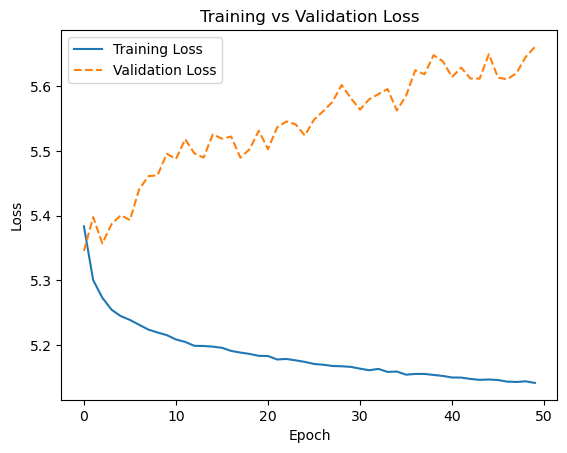

In [15]:
plt.plot(epoch_listings, train_loss_list, label='Training Loss')
plt.plot(epoch_listings, val_loss_list, label='Validation Loss', linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

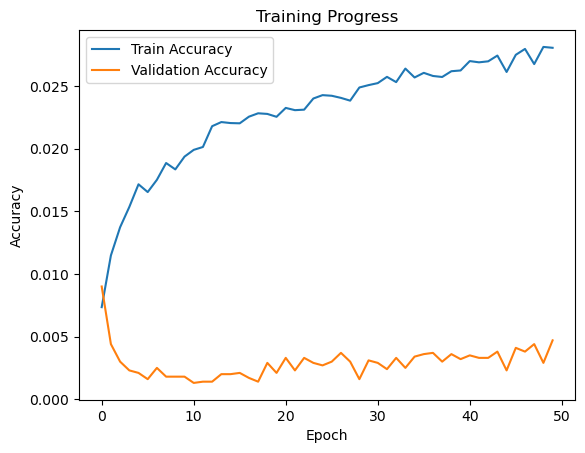

In [16]:
plt.plot(epoch_listings, train_acc_list, label="Train Accuracy")
plt.plot(epoch_listings, val_acc_list, label="Validation Accuracy")
#plt.plot(epoch_listings, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Progress")
plt.show()